# GRN inference from synthetic single cell RNA-seq data

**Caleb Reagor, CS5785 Term Project**

In [1]:
# script dependencies
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 1000
from IPython.display import Markdown
from synth_dataset import synthdata

Succesfully loaded previous model with the following parameters: n_tfs = 15, n_targets = 50, selfs = 0.8, frac = 0.5, strengths_min = 0.8, strengths_max = 1, k_strengths = 2


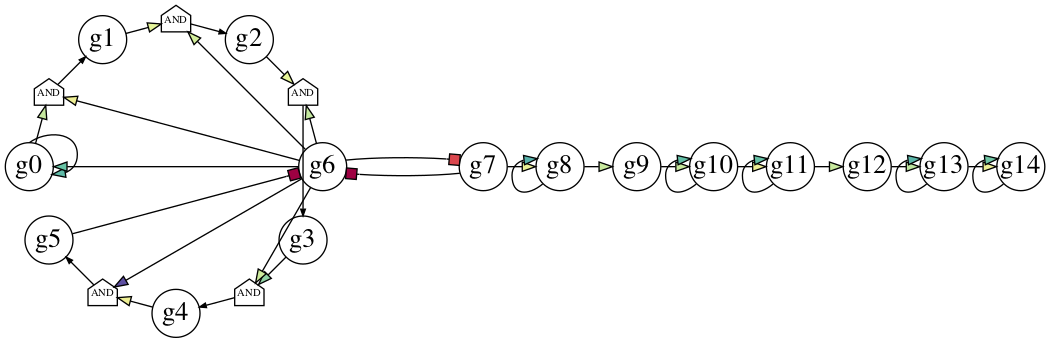

In [2]:
d = '/Users/calebreagor/Documents/hudspeth-lab/inputs'
d2 = '/Users/calebreagor/Documents/BoolODE-master'
d3 = '/Users/calebreagor/Documents/Beeline-master'
s = synthdata('linear_1', directory=d, boolODE_directory=d2, beeline_directory=d3)

"""
generate a gene regulatory network that mimics HC development
"""

s.generate_model(n_tfs=15, n_targets=50, selfs=0.8, frac=0.5, mindist=0.3, load_prev=True)

In [3]:
"""
generate synthetic single cell dataset(s) from the grn (BoolODE)
"""

s.simulate_model(sim_time=25, n_cells=300, drop_cutoff=0.7, drop_prob=0.7, n_datasets=10, load_prev=True)

Succesfully loaded previous simulations with the following parameters: sim_time = 25, n_cells = 300, drop_cutoff = 0.7, drop_prob = 0.7, par_std = 0.5, n_datasets = 10


Genes, from top-to-bottom: g6, g0-g5, g7-g14


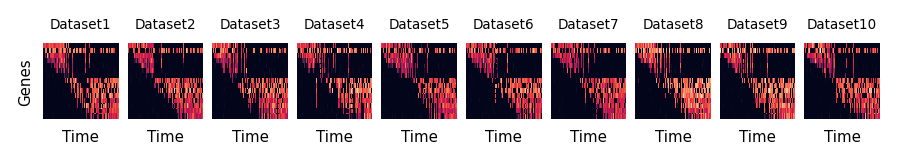

In [4]:
s.plot_expression(data='expression', dpi=180, datasets='all')

Succesfully loaded previous binding sites matrices with the following parameters: bindsite_prob = 0.1, pmf_true_bindsites = [0.2, 0.7, 0.1], pmf_others = [0.9, 0.09, 0.01], exclude_selfs = True

Genes, from top-to-bottom and left-to-right: g6, g0-g5, g7-g14


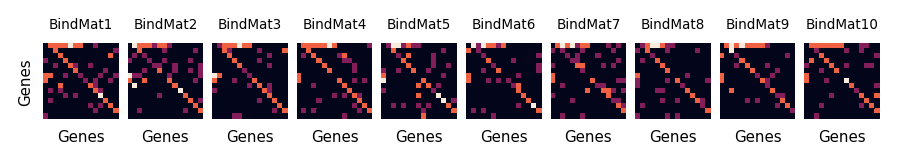

Proportion n bindsites:
1: 0.09029585798816567
2: 0.0207810650887574
3: 0.0024615384615384616


In [5]:
"""
generate binding sites matrices for each dataset given the grn
"""

s.generate_tfbs(bindsite_prob=0.1, pmf_true_bindsites=[0.2,0.7,0.1], 
                pmf_others=[0.9,0.09,0.01], load_prev=True, dpi=180)

In [6]:
s.infer_network(mode='beeline', pars='default', load_prev=True)

Succesfully loaded previous results from the following algorithms: SINCERITIES, PPCOR, GRNBOOST2, GENIE3, PIDC


In [7]:
s.infer_network(mode='lasso', pars='default', load_prev=False)

Performing Lasso with n=7 training datasets...


<AxesSubplot:>

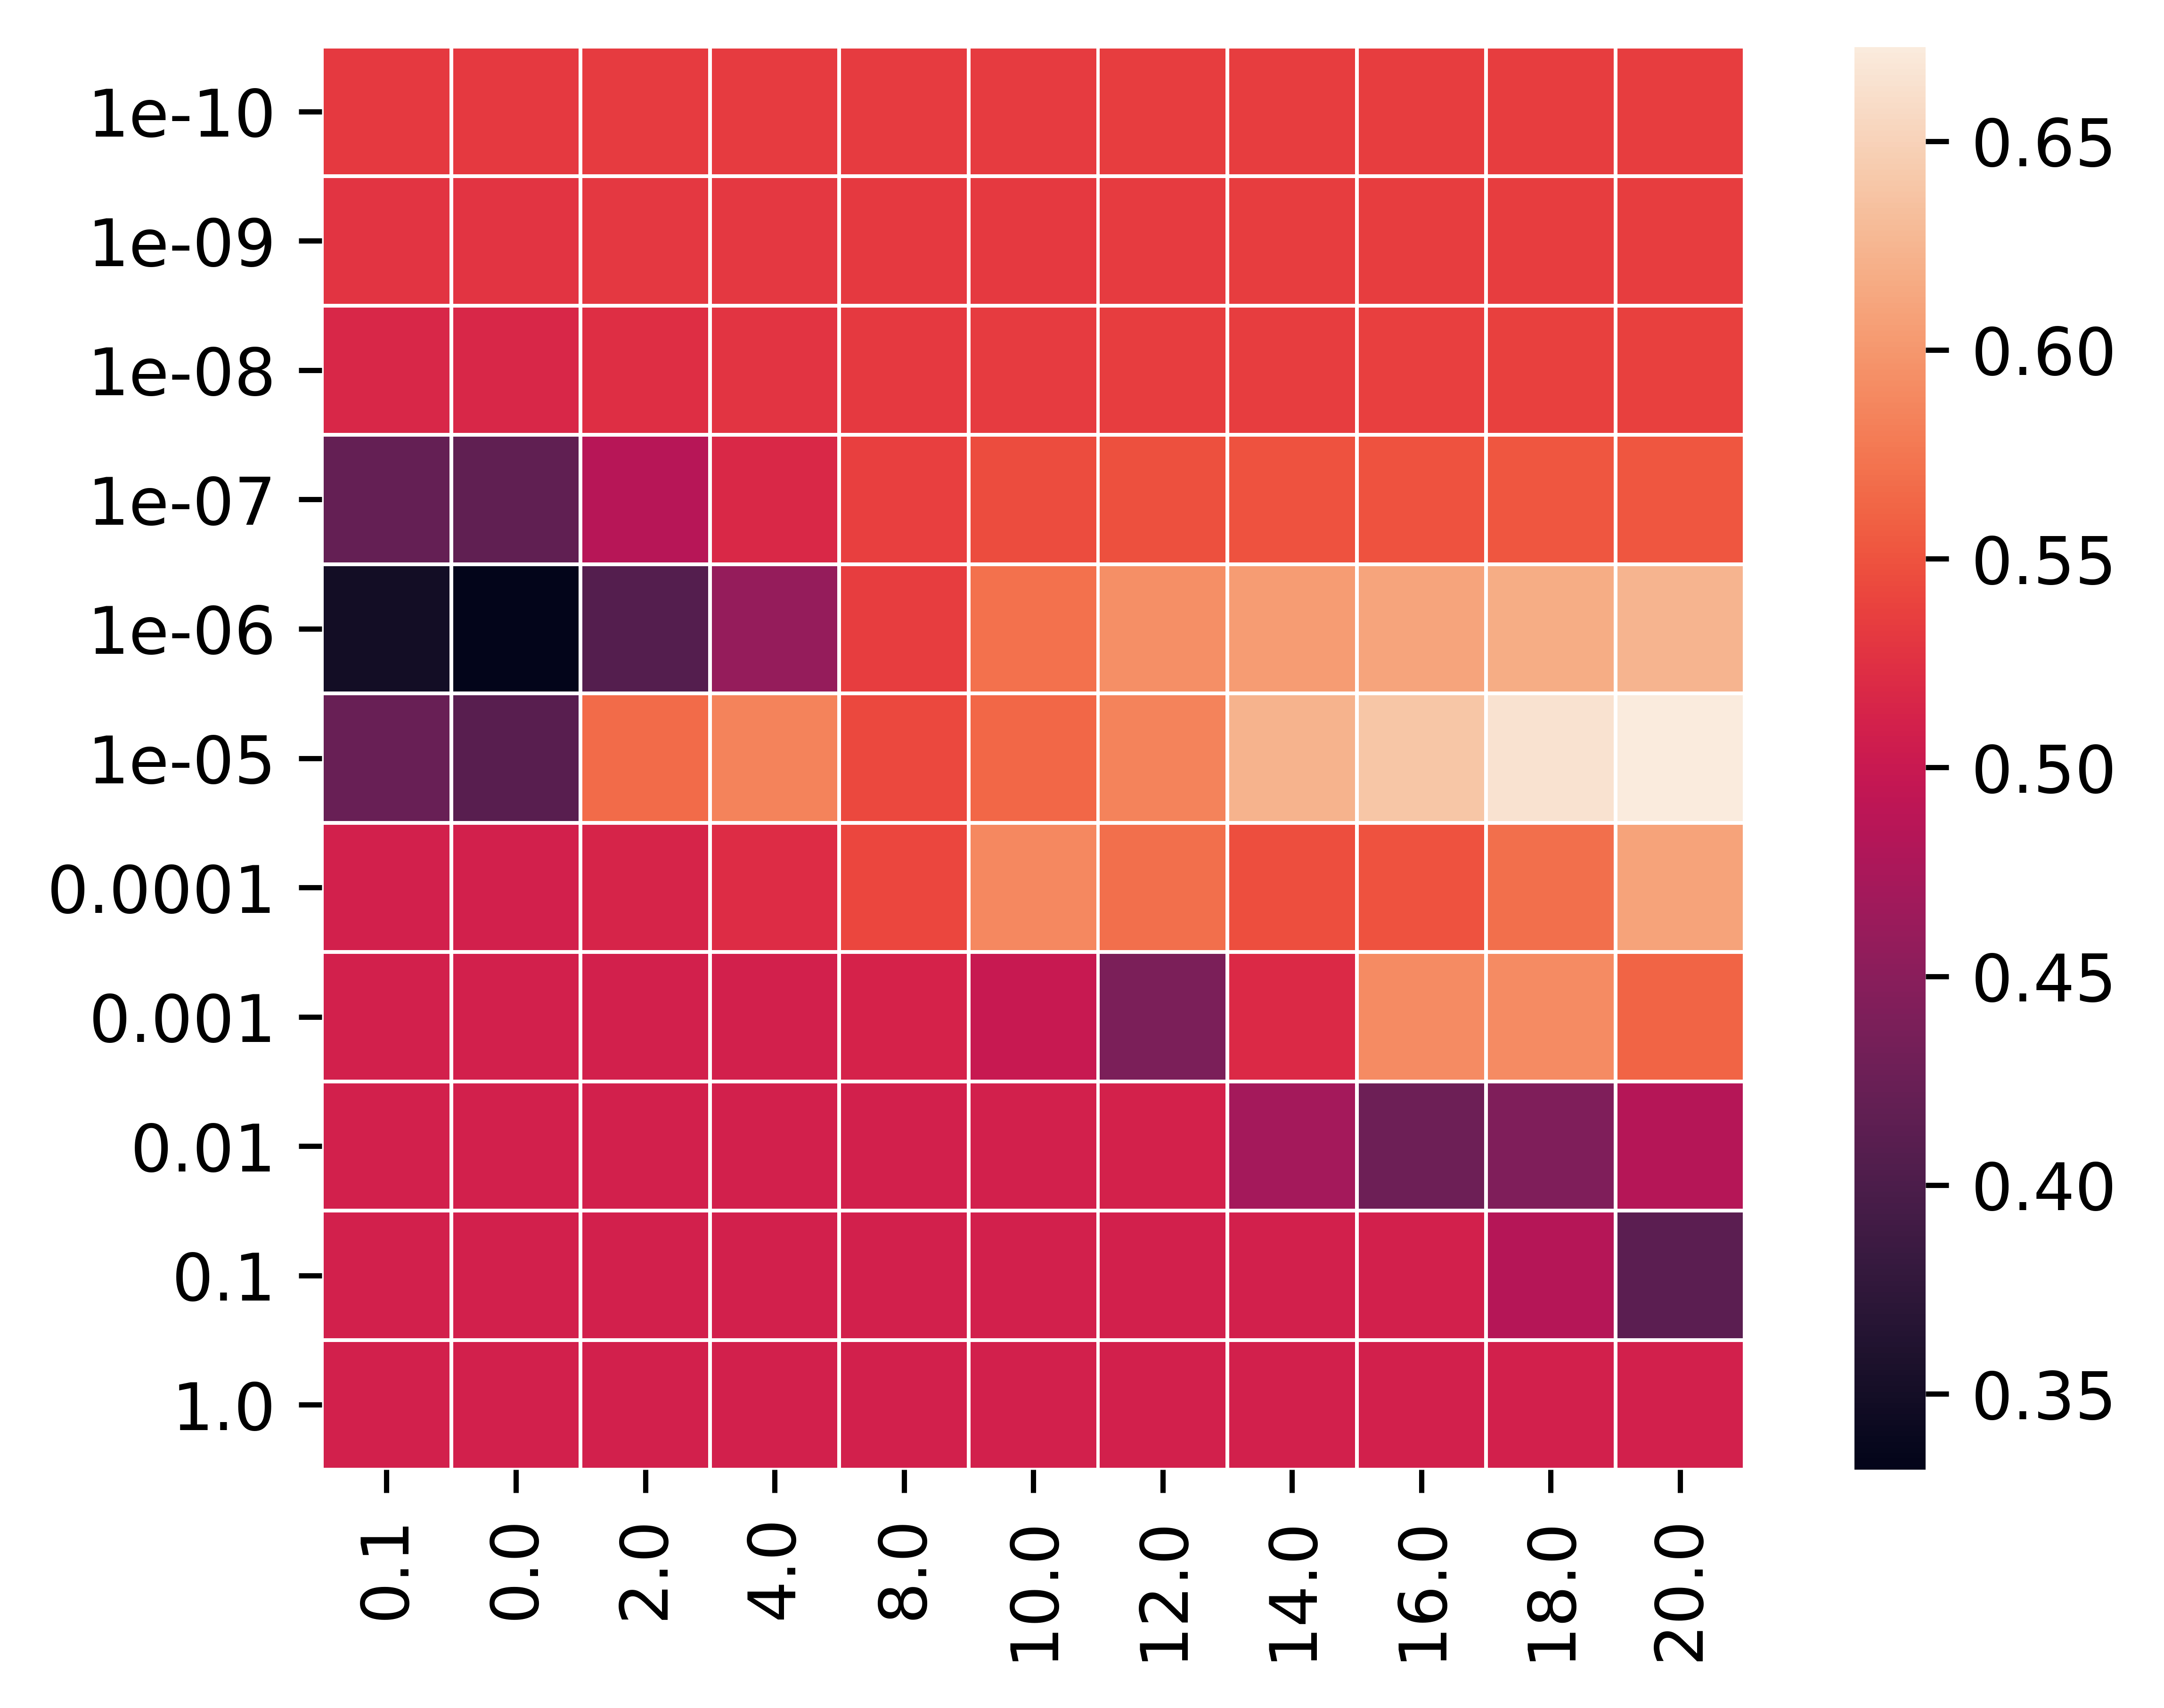

In [9]:
sns.heatmap(s.lasso_grid, square=True, linewidths=0.5)

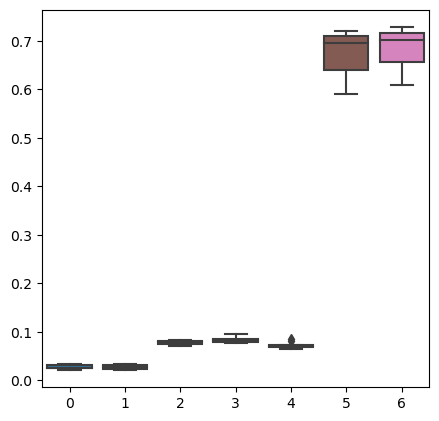

In [64]:
results = s.bee_auc.append(s.lasso_auc.loc['ABLASSO'])
results.loc['ABLASSO',s.lasso_auc.loc['split']=='dev'] = None
results.index.values[-1] = 'ABLASSO-train'

results = results.append(s.lasso_auc.loc['ABLASSO'])
results.loc['ABLASSO',s.lasso_auc.loc['split']=='train'] = None
results.index.values[-1] = 'ABLASSO-dev'

dpi_prev = mpl.rcParams['figure.dpi']
mpl.rcParams['figure.dpi'] = 100

plt.figure(figsize=(5,5))
sns.boxplot(data=results.T.values)
plt.show(); mpl.rcParams['figure.dpi'] = dpi_prev

**Hooray! It works! I can recover most of the network by first biasing features by # binding sites, then running adaptive Lasso. Then, if I plot all genes with >1 target, the resulting graph shows many features of the ground truth (including the toggle switch).**  

**TO DO:**  
[x] Plot differentially expressed TFs from real scRNA-seq data for reference  
[X] Remove putative and non-specific TFs from reference files & re-run FIMO  
[X] Write function to generate_tfbs() within synthdata class file  
[X] Manually remove extra genes from existing grn file and re-run BoolODE  
[X] Write function to perform grid search for ABLasso hyperparameter tuning  
[ ] Collect motif data for remaining TFs, then re-run FIMO, then synthetic data 
* Make sure # motifs matches # sequences and annotated list in excel

In [ ]:
i, alpha, beta = 9, 1e-5, 20
_, adj = auprc(s.expression[i][s.tfbs[i].columns], 
                   (1/s.tfbs[i]).replace(np.inf, 0), 
                   alpha, beta, return_adj=True)

In [ ]:
import networkx as nx
from IPython.display import Image

G = nx.convert_matrix.from_pandas_adjacency(adj, create_using=nx.DiGraph)

for i,j in G.edges:
    if adj.loc[i,j] < 0:
        G[i][j]['arrowhead'] = 'box'
        
G.graph['node'] = {'shape' : 'circle',
                   'fixedsize' : 'True',
                   'fontsize' : '20'}

G.graph['edge'] = {'arrowsize' : '1.0'}

outdeg = G.out_degree()
G.remove_nodes_from([n[0] for n in outdeg if n[1]<3])

# outdeg = G.out_degree()
# G.remove_nodes_from([n[0] for n in outdeg if n[1]==0])

A = nx.nx_agraph.to_agraph(G)
A.layout('circo', args=f'-Gmindist=0.8')
Image(A.draw(format='png'))

**Code to generate figure from original report:**

In [ ]:
# # CODE TO PLOT BEELINE EVAL RESULTS
# from matplotlib.lines import Line2D

# density = s.grn.values.nonzero()[0].size/(s.grn.shape[1]*(s.grn.shape[1] - 1)/2)

# auroc = pd.read_csv('outputs/linear_1/linear_1-AUROC.csv', index_col=0)
# auprc = pd.read_csv('outputs/linear_1/linear_1-AUPRC.csv', index_col=0)

# matplotlib.rcParams['figure.dpi']= 150
# fig, ax = plt.subplots(2,1,figsize=(2,4), sharex=True)

# w, c, sz = 0.5, ['k','tab:red'], 4

# auroc.T.boxplot(ax=ax[0], grid=False, widths=w, boxprops=dict(color=c[0]),
#                 whiskerprops=dict(color=c[0]), medianprops=dict(color=c[0]),
#                 capprops=dict(color=c[0]), flierprops=dict(markersize=sz, markeredgecolor=c[0], markerfacecolor=c[0]))
# auprc.T.boxplot(ax=ax[1], grid=False, widths=w, boxprops=dict(color=c[1]),
#                 whiskerprops=dict(color=c[1]), medianprops=dict(color=c[1]),
#                 capprops=dict(color=c[1]), flierprops=dict(markersize=sz, markeredgecolor=c[1], markerfacecolor=c[1]))

# plt.xticks(rotation=90)
# ax[0].yaxis.grid(True)
# ax[1].yaxis.grid(True)

# fig.text(-0.15, 0.5, 'AUC', va='center', rotation='vertical')

# ax[0].set_ylim(top=1.0)
# ax[1].set_ylim(bottom=0.0)

# ax[0].spines['bottom'].set_visible(False)
# ax[1].spines['top'].set_visible(False)
# ax[0].tick_params(labeltop=False)
# ax[0].tick_params(axis='x', bottom=False)
# ax[0].tick_params(axis='y', right=True)
# ax[1].tick_params(axis='y', right=True)

# d = .01  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
# ax[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
# ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# ax[0].axhline(0.5, linestyle='--', color='gray')
# ax[1].axhline(density, linestyle='--', color='rosybrown')

# lgnd = [Line2D([0], [0], color=c[0], lw=4),
#         Line2D([0], [0], color=c[1], lw=4)]

# ax[0].legend(lgnd, ['ROC', 'PR'], frameon=False)

# plt.show()